In [38]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import glob
convFiles=glob.glob("convProfs/*nc")

In [13]:
print(convFiles)
#!pwd

['convProfs/convProfs_20200701-02.nc', 'convProfs/convProfs_20200201-05.nc', 'convProfs/convProfs_20200601-02.nc', 'convProfs/convProfs_20200301-05.nc', 'convProfs/convProfs_20200401-02.nc', 'convProfs/convProfs_20200101-05.nc', 'convProfs/convProfs_20200501-02.nc', 'convProfs/convProfs_20200501-05.nc', 'convProfs/convProfs_20200401-05.nc', 'convProfs/convProfs_20200101-02.nc', 'convProfs/convProfs_20200601-05.nc', 'convProfs/convProfs_20200301-02.nc', 'convProfs/convProfs_20200701-05.nc', 'convProfs/convProfs_20200201-02.nc']


In [39]:
ntot=0
zKuL=[]
zKaL=[]
pRateDPRL=[]
pRateCMBL=[]
dmCMBL=[]
nodes2L=[]
for f in convFiles[:]:
    with nc.Dataset(f) as fh:
        hzero=fh['hzero'][:,4,4]
        zKu=fh['zKu'][:,4,4]
        zKa=fh['zKa'][:,4,4]
        bzd=fh['bzd'][:,4,4]
        bcf=fh['bcf'][:,4,4]
        precipDPR=fh['precip'][:,4,4]
        precipCMB=fh['precipCMB'][:,4,4]  
        dmCMB=fh['dmCMB'][:,4,4] 
        n24=30
        a=np.nonzero(bcf-bzd>n24)

        for i in a[0]:
            
            nodes=list(range(bzd[i]-60,bzd[i]+n24))
            if nodes[0]%2==0:
                nodes2=nodes[::2]
            else:
                nodes2=nodes[1::2]
            
            nodes2=np.array(nodes2)//2
            nodes2L.append(nodes2)
            if precipCMB[i,nodes2[-1]]>-0.1:
                zKuL.append(zKu[i,bzd[i]-60:bzd[i]+n24])
                zKaL.append(zKa[i,bzd[i]-60:bzd[i]+n24])
                pRateDPRL.append(precipDPR[i,bzd[i]-60:bzd[i]+n24])
                pRateCMBL.append(precipCMB[i,nodes2])
                dmCMBL.append(dmCMB[i,nodes2])
        #print(fh)
        #break
        ntot+=len(a[0])
print(ntot)

59089


In [31]:
import xarray as xr
zKuX=xr.DataArray(np.array(zKuL),dims=['time','range'])
zKaX=xr.DataArray(np.array(zKaL),dims=['time','range'])
pRateCMBLX=xr.DataArray(np.array(pRateCMBL),dims=['time','range2'])
pRateDPRLX=xr.DataArray(np.array(pRateDPRL),dims=['time','range'])
dmCMBLX=xr.DataArray(np.array(dmCMBL),dims=['time','range2'])
nodes2LX=xr.DataArray(np.array(nodes2L),dims=['time','range2'])
ds=xr.Dataset({'zKu':zKuX,'zKa':zKaX,'pRateCMB':pRateCMBLX,'pRateDPR':pRateDPRLX,'dmCMB':dmCMBLX,'nodes2':nodes2LX})
#ds.to_netcdf('convProf_LSTM.nc')
compLev=5
encoding = {var: {'zlib': True, 'complevel': compLev} for var in ds.data_vars}
ds.to_netcdf('convProf_LSTM.nc',encoding=encoding)

In [34]:
pRateCMBL=np.array(pRateCMBL)
pRateDPRL=np.array(pRateDPRL)
print(np.corrcoef(pRateCMBL[:,-1],pRateDPRL[:,-1]))

[[1.         0.70368094]
 [0.70368094 1.        ]]


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BayesianLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, n_features=3, p=0.25):
        super(BayesianLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(n_features, hidden_size, num_layers, batch_first=True)
        # Define the output layer for mean
        self.fc_mean = nn.Linear(hidden_size, n_features)
        
        # Define the output layer for log(std)
        self.fc_log_std = nn.Linear(hidden_size, n_features)
        
        # Define the linear layer for z
        self.fc_z = nn.Linear(hidden_size, output_size)

        self.dropout_mean = nn.Dropout(p)
        self.dropout_logstd = nn.Dropout(p)
        self.dropout_z = nn.Dropout(p)
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        h0z = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Initialize cell state with zeros
        c0z = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        #print(x.shape)
        #print(h0.shape)
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        
        #Decode the hidden state of the last time step
        mean = self.fc_mean(out[:, :, :])
        log_std = self.fc_log_std(out[:, :, :])
        # Add dropout
        mean = self.dropout_mean(mean)
        log_std = self.dropout_logstd(log_std)
        # batch normalize mean and log_std
        #mean=self.bn_mean(mean)
        #log_std=self.bn_var(log_std)
        # Ensure standard deviation is positive
        std = torch.exp(log_std)
        
        # Reparameterization trick: sample from N(0, 1) and scale by std, then add mean
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        #print(z.shape)
        #print(h0z.shape)
        #print(h0z.shape)
        out2, _ = self.lstm2(z, (h0z, c0z))
        #print('got here')
        #print(out2.shape)   
        # Apply linear layer to z
        #z = self.dropout_z(z)
        z_out = self.fc_z(out2)
        
        return z_out, mean, log_std

import torch

def bayesian_loss(y_target, z, mean, log_std, prior_mean=0.0, prior_std=1.0):
    # Calculate the MSE loss
    mse_loss = F.mse_loss(z, y_target, reduction='mean')
    
    # Calculate the KL divergence
    kl_divergence = 0.5 * torch.mean(torch.exp(2 * log_std)/prior_std**2 + (mean-prior_mean) ** 2 - 1 - 2 * log_std + 2 * torch.log(torch.tensor(prior_std)))
    
    # Total loss
    loss = mse_loss + kl_divergence
    
    return loss

In [50]:
import numpy as np
model_lstm = BayesianLSTMModel(input_size=2, hidden_size=64, output_size=1, num_layers=1, p=0.1)
xinput=torch.tensor(np.random.randn(4,90,2),dtype=torch.float32)
y,mean,log_std=model_lstm(xinput)

59089


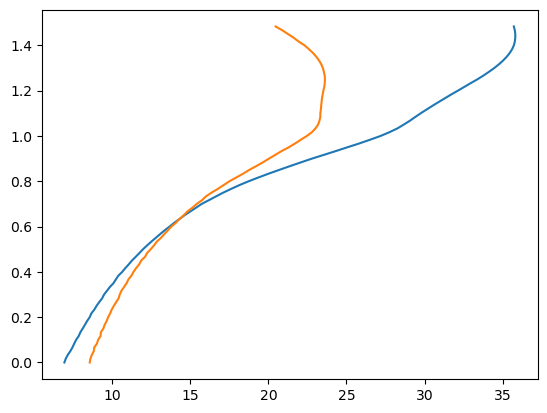

In [40]:
print(len(pRateCMBL))
nt=len(pRateCMBL)
X=np.zeros((nt,60+n24,3),float)
zKuL=np.array(zKuL)
zKaL=np.array(zKaL)
zKuL[zKuL<0]=0
zKaL[zKaL<0]=0
xrange=(np.arange(60+n24)-60.0)/60.0+1

import matplotlib.pyplot as plt
plt.plot(zKuL.mean(axis=0),xrange)
plt.plot(zKaL.mean(axis=0),xrange)
#plt.plot(zKuL[1000,:])
#plt.plot(zKaL[1000,:])
X[:,:,0]=zKuL/zKuL.std()
X[:,:,1]=zKaL/zKuL.std()
for k in range(nt):
    X[k,:,2]=xrange


In [41]:
print(y[0].shape)
pRateDPRL=np.array(pRateDPRL)
print(pRateDPRL.min(),pRateDPRL.max())
y=np.log(1+pRateDPRL)
print(y.min(),y.max(),y.mean(),y.std())
ymean=y.mean(axis=0)
ystd=y.std(axis=0)
y_scaled=(y-ymean)/ystd
y_scaled=y_scaled[:,:,np.newaxis]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)
# import torch dataset and torch Dataloader

from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_data = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
batch_size = 128
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

torch.Size([90, 1])
0.0 299.97
0.0 5.7070107 0.97676414 1.1221011


In [88]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, :, :])
        return out

In [51]:
#train model
bayesian_lstm = BayesianLSTMModel(input_size=2, hidden_size=16, output_size=1, num_layers=1, p=0.005)
y=bayesian_lstm(torch.tensor(X).float()[0:10,:,:2])
import torch.optim as optim
criterion = F.mse_loss
criterion = bayesian_loss
optimizer = optim.Adam(bayesian_lstm.parameters(), lr=0.001)


In [61]:

n_epochs = 10
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    ibatch=0
    for data, target in train_loader:
        optimizer.zero_grad()
        #z, mean, std = bayesian_lstm(data[:,:,0:2])
        z, mean, std = bayesian_lstm(data[:,:,0:2])
        #print(z.shape)
        #print(target.shape)
        loss = criterion(target, z, mean, std)
        #loss = criterion(target, z)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        ibatch+=1
    train_loss = train_loss / ibatch
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.258969
Epoch: 2 	Training Loss: 0.255942
Epoch: 3 	Training Loss: 0.254890
Epoch: 4 	Training Loss: 0.251947
Epoch: 5 	Training Loss: 0.251317
Epoch: 6 	Training Loss: 0.247443
Epoch: 7 	Training Loss: 0.244578
Epoch: 8 	Training Loss: 0.245346
Epoch: 9 	Training Loss: 0.243360
Epoch: 10 	Training Loss: 0.241784


In [62]:
print(dir(test_data))
y_pred1,mean1,logstd1=bayesian_lstm(test_data.tensors[0][:,:,0:2])
y_pred2,mean2,logstd2=bayesian_lstm(test_data.tensors[0][:,:,0:2])

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'tensors']


In [63]:
print(np.corrcoef(y_pred1.detach().numpy()[:,-1,0],y_pred2.detach().numpy()[:,-1,0]))
print(np.corrcoef(y_pred1.detach().numpy()[:,-1,0],test_data.tensors[1].detach().numpy()[:,-1,0]))

[[1.         0.86879033]
 [0.86879033 1.        ]]
[[1.        0.7140332]
 [0.7140332 1.       ]]
